### CITS4404 Practical Project

# Camo Worms!

<div style="margin-left: 0px">
    &nbsp;
    <img src="velvet-worms.jpg" width=600>
    <br>
    <br>
</div>

Australian _velvet worms_ come in many colours, possibly as a camouflage function ([Current Biology](https://www.cell.com/current-biology/comments/S0960-9822(11)00208-9)).

In [602]:
import sys
!{sys.executable} -m pip install -r ../requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [603]:
# Imports
import numpy as np
import imageio.v3 as iio
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.bezier as mbezier
from matplotlib.bezier import BezierSegment
from matplotlib.path import Path
from sklearn.metrics.pairwise import euclidean_distances

rng = np.random.default_rng()
Path = mpath.Path
mpl.rcParams['figure.dpi']= 72 #size of images


In [604]:
# Global variables
POPULATION_SIZE = 40
IMAGE_DIR = 'images'
IMAGE_NAME='original'
MASK = [320, 560, 160, 880] # ymin ymax xmin xmax

Image name (shape) (intensity max, min, mean, std)

original (240, 720) (210, 0, 49.3, 34.8)


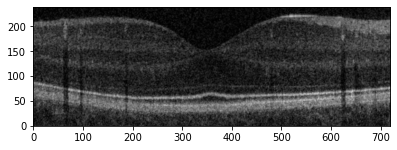

In [605]:
# Read, crop and display image and stats

def crop (image, mask):
    h, w = np.shape(image)
    return image[max(mask[0],0):min(mask[1],h), max(mask[2],0):min(mask[3],w)]

def prep_image (imdir, imname, mask):
    print("Image name (shape) (intensity max, min, mean, std)\n")
    image = np.flipud(crop(iio.imread(imdir+'/'+imname+".png"), mask))
    print("{} {} ({}, {}, {}, {})".format(imname, np.shape(image), np.max(image), np.min(image), round(np.mean(image),1), round(np.std(image),1)))
    plt.imshow(image, vmin=0, vmax=255, cmap='gray', origin='lower') # use vmin and vmax to stop imshow from scaling
    plt.show()
    return image

image = prep_image(IMAGE_DIR, IMAGE_NAME, MASK)

In [606]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.bezier import BezierSegment
from matplotlib.path import Path

class CamoWorm:
    def __init__(self, x, y, r, theta, deviation_r, deviation_gamma, width, colour):
        self.x = x
        self.y = y
        self.r = r
        self.theta = theta
        self.dr = deviation_r
        self.dgamma = deviation_gamma
        self.width = width
        self.colour = colour

        # Control points for the Bezier curve
        p0 = (self.x, self.y)
        p1 = (self.x + self.dr * np.cos(self.theta + self.dgamma), 
              self.y + self.dr * np.sin(self.theta + self.dgamma))
        p2 = (self.x + self.r * np.cos(self.theta), 
              self.y + self.r * np.sin(self.theta))

        self.bezier = BezierSegment(np.array([p0, p1, p2]))

    def generate_bezier_points(self, num_points=100):
        t_values = np.linspace(0, 1, num_points)
        points = [self.bezier.point_at_t(t) for t in t_values]
        x_points, y_points = zip(*points)
        return np.array(x_points, dtype=int), np.array(y_points, dtype=int)
    
    def control_points (self):
        return self.bezier.control_points
    def path (self):
        return mpath.Path(self.control_points(), [Path.MOVETO, Path.CURVE3, Path.CURVE3])

    def patch (self):
        return mpatches.PathPatch(self.path(), fc='None', ec=str(self.colour), lw=self.width, capstyle='round')
    
    


    def calculate_cost(self, image, other_worms):
        #environment_cost
        target_colour = image[int(self.y), int(self.x)] / 255.0
        x_points, y_points = self.generate_bezier_points()
        # Ensure points are within image boundaries
        x_points = np.clip(x_points, 0, image.shape[1]-1)
        y_points = np.clip(y_points, 0, image.shape[0]-1)
        intensity = image[y_points, x_points]
        environment_cost = np.mean(np.abs(intensity- target_colour))
        
        # Group knowledge cost
        position_cost = 0
        for other_worm in other_worms:
            if other_worm != self:
                distance = np.sqrt((self.x - other_worm.x)**2 + (self.y - other_worm.y)**2)
                position_cost += distance

        # Internal knowledge cost
        
        #size_cost = self.r
        '''
        p0 = (self.x, self.y)
        p1 = (self.x + self.dr * np.cos(self.theta + self.dgamma), 
              self.y + self.dr * np.sin(self.theta + self.dgamma))
        p2 = (self.x + self.r * np.cos(self.theta), 
              self.y + self.r * np.sin(self.theta))
        self.bezier = BezierSegment(np.array([p0, p1, p2]))
        vector1 = np.array(p1) - np.array(p0)
        vector2 = np.array(p2) - np.array(p1)
        norm1 = np.linalg.norm(vector1)
        norm2 = np.linalg.norm(vector2)
        if norm1 < 1e-8 or norm2 < 1e-8:
            angle = 0.0  
        else:
            angle = np.arccos(np.dot(vector1, vector2) / (norm1 * norm2))
        self.curvature = angle
        curvature_cost = self.curvature
        '''
        color_cost = np.mean(np.abs(self.colour - target_colour))
        
        worm_points = np.column_stack((x_points, y_points))
        colors = image[worm_points[:, 1], worm_points[:, 0]]
        color_std_dev = np.std(colors, axis=0)   
        color_uniformity_cost = np.sum(color_std_dev**2)




        return 2*environment_cost + position_cost  + 2*color_cost + 5*color_uniformity_cost
    
    def grow(self):
        self.r = np.random.uniform(50,70) 
        self.width = np.random.uniform(3, 5)
    def move(self, image_shape):
        self.x = np.random.randint(0, image_shape[1])  # Random x-coordinate
        self.y = np.random.randint(0, image_shape[0])  # Random y-coordinate
        
    def adapt_color(self, image):
        # Get the color of the pixel at the worm's position
        color = image[int(self.y), int(self.x)]
        color = color / 255
        # Set the worm's color to the color of the pixel
        self.colour = color
    def adapt_curvature(self):
        # Adjust the curvature based on some strategy
        self.dgamma = np.random.uniform(0, np.pi)
        self.theta = np.random.uniform(-np.pi/6, np.pi/6)
        self.dr = np.random.uniform(-50, 100)
        
        # Recalculate the control points for the Bezier curve
        p0 = [self.x - self.r * np.cos(self.theta), self.y - self.r * np.sin(self.theta)]
        p2 = [self.x + self.r * np.cos(self.theta), self.y + self.r * np.sin(self.theta)]
        p1 = [self.x + self.dr * np.cos(self.theta+self.dgamma), self.y + self.dr * np.sin(self.theta+self.dgamma)]
        self.bezier = mbezier.BezierSegment(np.array([p0, p1,p2]))
        


In [607]:
class Drawing:
    def __init__ (self, image):
        self.fig, self.ax = plt.subplots()
        self.image = image
        self.im = self.ax.imshow(self.image, cmap='gray', origin='lower')

    def add_patches(self, patches):
        try:
            for patch in patches:
                self.ax.add_patch(patch)
        except TypeError:
            self.ax.add_patch(patches)

    def add_dots(self, points, radius=4, **kwargs):
        try:
            for point in points:
                self.ax.add_patch(mpatches.Circle((point[0],point[1]), radius, **kwargs))
        except TypeError:
            self.ax.add_patch(mpatches.Circle((points[0],points[1]), radius, **kwargs))

    def add_worms(self, worms):
        try:
            self.add_patches([w.patch() for w in worms])
        except TypeError:
            self.add_patches([worms.patch()])

    def show(self, save=None):
        if save is not None:
            plt.savefig(save)
        plt.show()


In [608]:
class Population:
    def __init__(self, size, image_shape):
        self.worms = [self.create_random_worm(image_shape) for _ in range(size)]
        self.image_shape = image_shape

    def create_random_worm(self, image_shape):
        x = np.random.randint(0, image_shape[1])
        y = np.random.randint(0, image_shape[0])
        r = np.random.randint(10, 70)
        theta = np.random.rand() * np.pi
        deviation_r = np.random.randint(-50, 50)
        deviation_gamma = np.random.rand() * np.pi
        width = np.random.randint(1, 5)
        colour = np.random.rand()
        return CamoWorm(x, y, r, theta, deviation_r, deviation_gamma, width, colour)

    def evaluate_fitness(self, image, other_worms):
        for worm in self.worms:
            worm.fitness = 1 / (1 + worm.calculate_cost(image, other_worms))

    def select(self):
        self.worms.sort(key=lambda x: x.fitness, reverse=True)
        self.worms = self.worms[:len(self.worms)//2]  # Keep top 50%
        self.worms = self.worms * 2

    def crossover(self):
        new_generation = []
        while len(new_generation) < len(self.worms) * 2:
            if len(self.worms) >= 2:
                parent1, parent2 = np.random.choice(self.worms, 2, replace=False)
                child1, child2 = self.mate(parent1, parent2)
                new_generation.extend([child1, child2])
            else:
                break
        self.worms = new_generation[:len(self.worms)]

    def mate(self, parent1, parent2):
        # Simple averaging crossover
        child1 = CamoWorm(
            (parent1.x+parent2.x) // 2,
            (parent1.y+parent2.y) // 2,
            (parent1.r + parent2.r) // 2,
            (parent1.theta + parent2.theta) / 2,
            (parent1.dr + parent2.dr) // 2,
            (parent1.dgamma + parent2.dgamma) / 2,
            (parent1.width + parent2.width) // 2,
            (parent1.colour + parent2.colour) / 2
        )
        child2 = CamoWorm(
             (parent2.x+parent1.x) // 2,
             parent2.y+parent1.y // 2,
            (parent1.r + parent2.r) // 2,
            (parent1.theta + parent2.theta) / 2,
            (parent1.dr + parent2.dr) // 2,
            (parent1.dgamma + parent2.dgamma) / 2,
            (parent1.width + parent2.width) // 2,
            (parent1.colour + parent2.colour) / 2
        )
        return child1, child2
    

Best generation: Cost = 3556.4058086640407


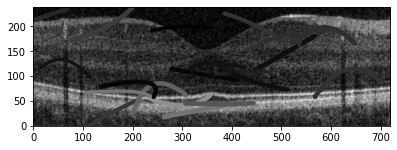

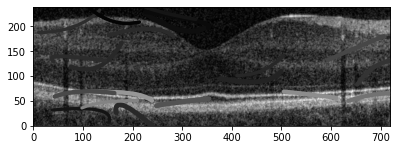

In [609]:

def run_genetic_algorithm(image, generations=200):
    population = Population(20, image.shape)
    min_cost = float('inf')
    best_worms = None
    for i in range(200):
        population.evaluate_fitness(image,population.worms)
        population.select()
        population.crossover()
        for worm in population.worms:
            worm.grow()
            worm.move(image.shape)
            worm.adapt_color(image)
            worm.adapt_curvature()
        cost = worm.calculate_cost(image, population.worms)
        if cost < min_cost:
            min_cost = cost
            best_worms = population.worms.copy()
    print(f"Best generation: Cost = {min_cost}")
    visualize_population(best_worms, image)
    return population


def visualize_population(worms, image):
    drawing = Drawing(image)
    drawing.add_worms(worms)  
    drawing.show()
# Example usage
optimized_population = run_genetic_algorithm(image)
drawing = Drawing(image)
drawing.add_worms(optimized_population.worms)
drawing.show()



&copy; Cara MacNish, UWA, 2024